*** debug parameter set: this is a test run for debugging purposes ***
loading train data...
loading test data...
Extracting new features...
('\nCounting unqiue ', 'channel', ' by ', ['ip'], '... and saved in', 'ip_by_channel_countuniq')
('\nCounting unqiue ', 'app', ' by ', ['ip', 'device', 'os'], '... and saved in', 'ip_device_os_by_app_countuniq')
('\nCounting unqiue ', 'hour', ' by ', ['ip', 'day'], '... and saved in', 'ip_day_by_hour_countuniq')
('\nCounting unqiue ', 'app', ' by ', ['ip'], '... and saved in', 'ip_by_app_countuniq')
('\nCounting unqiue ', 'os', ' by ', ['ip', 'app'], '... and saved in', 'ip_app_by_os_countuniq')
('\nCounting unqiue ', 'device', ' by ', ['ip'], '... and saved in', 'ip_by_device_countuniq')
('\nCounting unqiue ', 'channel', ' by ', ['app'], '... and saved in', 'app_by_channel_countuniq')
('\nCumulative count by ', ['ip'], '... and saved in', 'ip_by_os_cumcount')
('\nCumulative count by ', ['ip', 'os', 'device'], '... and saved in', 'ip_os_device_by_

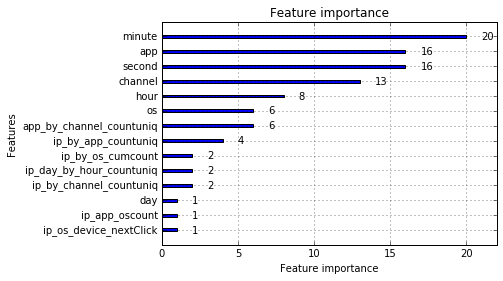

Predicting...
done...


In [10]:

"""
If you find this kernel helpful please upvote. Also any suggestion for improvement will be warmly welcomed.
I made cosmetic changes in the [code](https://www.kaggle.com/aharless/kaggle-runnable-version-of-baris-kanber-s-lightgbm/code). 
Added some new features. Ran for 25mil chunk rows.
Also taken ideas from various public kernels.
"""
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

FILENO= 6 #To distinguish the output file name.
debug=1  #Whethere or not in debuging mode


###### Feature extraction ######

#### Extracting next click feature 
    ### Taken help from https://www.kaggle.com/nanomathias/feature-engineering-importance-testing
    ###Did some Cosmetic changes 
predictors=[]
def do_next_prev_Click( df,agg_suffix, agg_type='float32'):
    print('Extracting new features...')
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('int8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('int8')
    
    #### New added
    df['minute'] = pd.to_datetime(df.click_time).dt.minute.astype('int8')
    predictors.append('minute')
    df['second'] = pd.to_datetime(df.click_time).dt.second.astype('int8')
    predictors.append('second')
    #print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    # {'groupby': ['ip']},
    # {'groupby': ['ip', 'app']},
    # {'groupby': ['ip', 'channel']},
    # {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        #print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        if agg_suffix=="nextClick":
            df[new_feature] = (df[all_features].groupby(spec[
            'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)
        elif agg_suffix== "prevClick":
            df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        predictors.append(new_feature)
        gc.collect()
#         print('predictors',predictors)
    return (df)




## Below a function is written to extract count feature by aggregating different cols
def do_count( df, group_cols, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )
    
##  Below a function is written to extract unique count feature from different cols
def do_countuniq( df, group_cols, counted, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )
### Below a function is written to extract cumulative count feature  from different cols    
def do_cumcount( df, group_cols, counted,agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )
### Below a function is written to extract mean feature  from different cols
def do_mean( df, group_cols, counted, agg_type='float32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_mean'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating mean of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_type='float32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_var'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating variance of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

###  A function is written to train the lightGBM model with different given parameters
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=50, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.4,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 10,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.9,  # L1 regularization term on weights
        'reg_lambda': 0.9,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)
    
## Running the full calculation.

#### A function is written here to run the full calculation with defined parameters.

#def DO(frm,to,fileno):
def DO(fileno):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint8',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }

    print('loading train data...')
    #train_df = pd.read_csv("../input/train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    train_df =  pd.read_csv("train_sample.csv", parse_dates=['click_time'],  nrows=100000, dtype=dtypes)

    print('loading test data...')
    #if debug:
    #    test_df = pd.read_csv("../input/test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    #else:
    #    test_df = pd.read_csv("../input/test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    test_df =  pd.read_csv("test.csv", parse_dates=['click_time'],  nrows=100000, dtype=dtypes)
    #test_df =  pd.read_csv("test.csv", parse_dates=['click_time'], dtype=dtypes)
    len_train = len(train_df)
    train_df=train_df.append(test_df)
    
    del test_df
        
    gc.collect()
    train_df = do_next_prev_Click( train_df,agg_suffix='nextClick', agg_type='float32'  ); gc.collect()
    # train_df = do_next_prev_Click( train_df,agg_suffix='prevClick', agg_type='float32'  ); gc.collect()  ## Removed temporarily due RAM sortage. 
    train_df = do_countuniq( train_df, ['ip'], 'channel' ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app'); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'day'], 'hour' ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'app'); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'app'], 'os'); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'device'); gc.collect()
    train_df = do_countuniq( train_df, ['app'], 'channel'); gc.collect()
    train_df = do_cumcount( train_df, ['ip'], 'os'); gc.collect()
    train_df = do_cumcount( train_df, ['ip', 'os', 'device'], 'app'); gc.collect()
    train_df = do_count( train_df, ['ip', 'day', 'hour'] ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app']); gc.collect()
    train_df = do_count( train_df, ['ip', 'app', 'os']); gc.collect()
    #train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour'); gc.collect()
    #train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour'); gc.collect()
    #train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day'); gc.collect()
    #train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour' ); gc.collect()
    
    print(train_df.head(5))
    gc.collect()
    
    
    print('\n\nBefore appending predictors...\n\n',sorted(predictors))
    target = 'is_attributed'
    word= ['app','device','os', 'channel', 'hour', 'day','minute', 'second']
    for feature in word:
        if feature not in predictors:
            predictors.append(feature)
    categorical = ['app', 'device', 'os', 'channel', 'hour', 'day','minute', 'second']
    print('\n\nAfter appending predictors...\n\n',sorted(predictors))

    test_df = train_df[len_train:]
    val_df = train_df[(len_train-val_size):len_train]
    train_df = train_df[:(len_train-val_size)]

    print("\ntrain size: ", len(train_df))
    print("\nvalid size: ", len(val_df))
    print("\ntest size : ", len(test_df))

    sub = pd.DataFrame()
    sub['click_id'] = test_df['click_id'].astype('int')

    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.20,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 200,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 200,  # Number of bucketed bin for feature values
        'subsample': 0.8,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':400 # because training data is extremely unbalanced 
    }
    (bst,best_iteration) = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_df, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()


    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()
    plt.savefig('foo.png')

    print("Predicting...")
    sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
#     if not debug:
#         print("writing...")
    sub.to_csv('sub_it%d.csv'%(fileno),index=False,float_format='%.9f')
    print("done...")
    return sub
    
    
####### Chunk size defining and final run  ############

#nrows=184903891-1
#nchunk=25000000
#val_size=2500000
val_size=10000

#frm=nrows-65000000
#if debug:
    #frm=0
    #nchunk=100000
    #val_size=10000

#to=frm+nchunk

#sub=DO(frm,to,FILENO)
sub =DO(FILENO)